In [1]:
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q ultralytics opencv-python matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 12.3 MB/s eta 0:00:00


In [2]:
# Step 2: Data Preparation
from google.colab import drive
drive.mount('/content/drive')

# Extract dataset
!pip install patool
import patoolib
rar_path = '/content/drive/My Drive/new_OPA.rar'
patoolib.extract_archive(rar_path, outdir="/content/opa_dataset")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 2.1 MB/s eta 0:00:00


INFO patool: Extracting /content/drive/My Drive/new_OPA.rar ...
INFO:patool:Extracting /content/drive/My Drive/new_OPA.rar ...
INFO patool: ... creating output directory `/content/opa_dataset'.
INFO:patool:... creating output directory `/content/opa_dataset'.
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_OPA.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/drive/My Drive/new_OPA.rar"
INFO patool: ... /content/drive/My Drive/new_OPA.rar extracted to `/content/opa_dataset'.
INFO:patool:... /content/drive/My Drive/new_OPA.rar extracted to `/content/opa_dataset'.


'/content/opa_dataset'

In [4]:
!pip install rembg onnxruntime
# Imports
import os
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image
import random

# Configuration
IMG_SIZE = (224, 224)  # Increased for better quality
BATCH_SIZE = 32
NUM_EPOCHS = 10
DATA_SAMPLE = 500  # Increased sample size for better training
OUTPUT_SIZE = (1024, 1024)  # Higher resolution output

# Load and prepare dataset
train_df = pd.read_csv('/content/opa_dataset/new_OPA/train_set.csv').sample(DATA_SAMPLE, random_state=42)
test_df = pd.read_csv('/content/opa_dataset/new_OPA/test_set.csv').sample(DATA_SAMPLE//2, random_state=42)

# Load backgrounds
def load_backgrounds():
    bg_dir = "/content/opa_dataset/new_OPA/background"
    backgrounds = []
    bg_categories = os.listdir(bg_dir)

    for category in bg_categories:
        category_path = os.path.join(bg_dir, category)
        if os.path.isdir(category_path):
            for bg_file in os.listdir(category_path):
                if bg_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    bg_path = os.path.join(category_path, bg_file)
                    bg = cv2.imread(bg_path)
                    if bg is not None:
                        bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
                        backgrounds.append(bg)

    print(f"Loaded {len(backgrounds)} background images")
    return backgrounds

backgrounds = load_backgrounds()

def load_data(df):
    images, annotations = [], []
    for _, row in df.iterrows():
        try:
            img_path = os.path.join("/content/opa_dataset/new_OPA/composite",
                                   row['img_name'].split('/', 2)[-1])
            image = cv2.imread(img_path)
            if image is None:
                continue

            # Resize and normalize
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMG_SIZE)

            # Extract annotations
            position = eval(row['position'])
            h, w = image.shape[:2]
            annotations.append([
                position[0] / w, position[1] / h,  # x, y
                position[2] / w, position[3] / h  # width, height
            ])
            images.append(image)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
    return np.array(images), np.array(annotations)

# Load datasets
train_images, train_ann = load_data(train_df)
test_images, test_ann = load_data(test_df)

# Dataset and DataLoader
class PlacementDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image.transpose(2, 0, 1) / 255.0, dtype=torch.float32)

        return image, torch.tensor(self.annotations[idx], dtype=torch.float32)

# Data augmentation transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = PlacementDataset(train_images, train_ann, transform=train_transform)
test_dataset = PlacementDataset(test_images, test_ann)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple CNN model for object placement prediction
class PlacementNet(nn.Module):
    def __init__(self):
        super(PlacementNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize model
model = PlacementNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'placement_model.pth')
print("Training completed and model saved.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.5 MB/s eta 0:00:00
Loaded 1680 background images
Epoch 1/10, Loss: 0.3676
Epoch 2/10, Loss: 0.3253
Epoch 3/10, Loss: 0.3163
Epoch 4/10, Loss: 0.3074
Epoch 5/10, Loss: 0.2946
Epoch 6/10, Loss: 0.2818
Epoch 7/10, Loss: 0.2720
Epoch 8/10, Loss: 0.2569
Epoch 9/10, Loss: 0.2509
Epoch 10/10, Loss: 0.2377
Training completed and model saved.


In [5]:
# Advanced Object Placement with Realistic Effects
class AdvancedObjectPlacer:
    def __init__(self, model, backgrounds):
        self.model = model
        self.backgrounds = backgrounds
        self.device = device

    def remove_background(self, img):
        """Remove background from an image using rembg library"""
        # Convert to PIL Image
        pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_RGB2RGBA) if img.shape[2] == 3 else img)

        # Remove background
        output = remove(pil_img)

        # Convert back to numpy array
        img_no_bg = np.array(output)

        return img_no_bg

    def create_alpha_mask(self, img):
        """Create a binary mask from the image"""
        if img.shape[2] == 4:  # RGBA
            # Use alpha channel as mask
            return img[:, :, 3]
        else:  # RGB
            # Create mask based on non-white pixels
            diff = np.sum(np.abs(img - [255, 255, 255]), axis=2)
            mask = (diff > 30).astype(np.uint8) * 255
            return mask

    def add_realistic_shadow(self, bg, obj_pos, obj_size):
        """Add a realistic shadow to the background based on object position and size"""
        shadow = np.zeros((bg.shape[0], bg.shape[1]), dtype=np.float32)
        x, y = obj_pos
        w, h = obj_size

        # Shadow parameters
        shadow_w = int(w * 1.1)
        shadow_h = int(h * 0.3)
        shadow_x = x + w//2 - shadow_w//2
        shadow_y = y + h - shadow_h//2

        # Create shadow ellipse
        cv2.ellipse(shadow,
                   (shadow_x + shadow_w//2, shadow_y + shadow_h//2),
                   (shadow_w//2, shadow_h//2),
                   0, 0, 360, 1, -1)

        # Blur shadow
        shadow = cv2.GaussianBlur(shadow, (25, 25), 10)

        # Create shadow RGB image
        shadow_rgb = np.zeros_like(bg)
        for c in range(3):
            shadow_rgb[:, :, c] = shadow * 255

        # Blend shadow with background
        shadow_strength = 0.3  # Adjust shadow darkness
        return cv2.addWeighted(bg, 1, shadow_rgb.astype(np.uint8), -shadow_strength, 0)

    def blend_with_background(self, bg, fg, mask, position):
        """Blend foreground object with background using mask"""
        x, y = position
        h, w = fg.shape[:2]

        # Create RGB foreground if RGBA
        if fg.shape[2] == 4:
            # Convert to RGB with proper alpha blending
            rgb = fg[:, :, :3]
            alpha = fg[:, :, 3] / 255.0
            alpha = np.stack([alpha, alpha, alpha], axis=2)
            fg_rgb = rgb.copy()
        else:
            fg_rgb = fg
            alpha = np.stack([mask/255.0, mask/255.0, mask/255.0], axis=2)

        # Ensure valid ranges
        x_start = max(0, x)
        y_start = max(0, y)
        x_end = min(bg.shape[1], x + w)
        y_end = min(bg.shape[0], y + h)

        # Calculate offsets for foreground
        fg_x_start = x_start - x
        fg_y_start = y_start - y
        fg_x_end = fg_x_start + (x_end - x_start)
        fg_y_end = fg_y_start + (y_end - y_start)

        # Get ROIs
        bg_roi = bg[y_start:y_end, x_start:x_end].copy()
        fg_roi = fg_rgb[fg_y_start:fg_y_end, fg_x_start:fg_x_end]
        alpha_roi = alpha[fg_y_start:fg_y_end, fg_x_start:fg_x_end]

        # Blend
        result = bg.copy()
        result[y_start:y_end, x_start:x_end] = bg_roi * (1 - alpha_roi) + fg_roi * alpha_roi

        return result

    def place_object(self, object_img, desired_bg=None):
        """Place an object into a background using the trained model for position prediction"""
        # Ensure RGB format
        if object_img.shape[2] == 4:  # If RGBA
            # Keep the original with alpha
            original_rgba = object_img.copy()
            # Convert to RGB for model input
            object_img_rgb = cv2.cvtColor(object_img, cv2.COLOR_RGBA2RGB)
        else:
            object_img_rgb = object_img.copy()
            # Remove background if RGB
            original_rgba = self.remove_background(object_img_rgb)

        # Get original dimensions
        original_h, original_w = object_img_rgb.shape[:2]
        aspect_ratio = original_w / original_h

        # Process input image for model (resize to expected input size)
        model_input = cv2.resize(object_img_rgb, IMG_SIZE)

        # Select background
        if desired_bg is None:
            bg = self.backgrounds[np.random.randint(len(self.backgrounds))].copy()
        else:
            bg = desired_bg.copy()

        # Resize background to desired output size
        bg = cv2.resize(bg, OUTPUT_SIZE)

        # Get placement prediction from model
        with torch.no_grad():
            input_tensor = torch.tensor(
                model_input.transpose(2, 0, 1)[None] / 255.0,
                dtype=torch.float32
            ).to(self.device)

            pred = self.model(input_tensor).cpu().numpy()[0]

        # Calculate position and size
        bg_h, bg_w = bg.shape[:2]

        # Get predicted center and dimensions as pixels
        center_x = int(pred[0] * bg_w)
        center_y = int(pred[1] * bg_h)
        pred_w = int(pred[2] * bg_w)
        pred_h = int(pred[3] * bg_h)

        # Calculate appropriate size while maintaining aspect ratio
        if aspect_ratio > 1:  # wider than tall
            w = min(pred_w, int(bg_w * 0.6))  # Don't let it get too wide
            h = int(w / aspect_ratio)
        else:  # taller than wide
            h = min(pred_h, int(bg_h * 0.6))  # Don't let it get too tall
            w = int(h * aspect_ratio)

        # Resize object
        resized_obj = cv2.resize(original_rgba, (w, h))

        # Create mask from alpha channel or object
        mask = self.create_alpha_mask(resized_obj)

        # Calculate top-left position
        x = center_x - w // 2
        y = center_y - h // 2

        # Ensure object is within bounds
        x = max(0, min(x, bg_w - w))
        y = max(0, min(y, bg_h - h))

        # Add shadow to background
        bg_with_shadow = self.add_realistic_shadow(bg, (x, y), (w, h))

        # Blend object with background
        result = self.blend_with_background(bg_with_shadow, resized_obj, mask, (x, y))

        # Ensure the output is proper RGB
        result = np.clip(result, 0, 255).astype(np.uint8)

        return result

Saving 1114569.jpg to 1114569.jpg


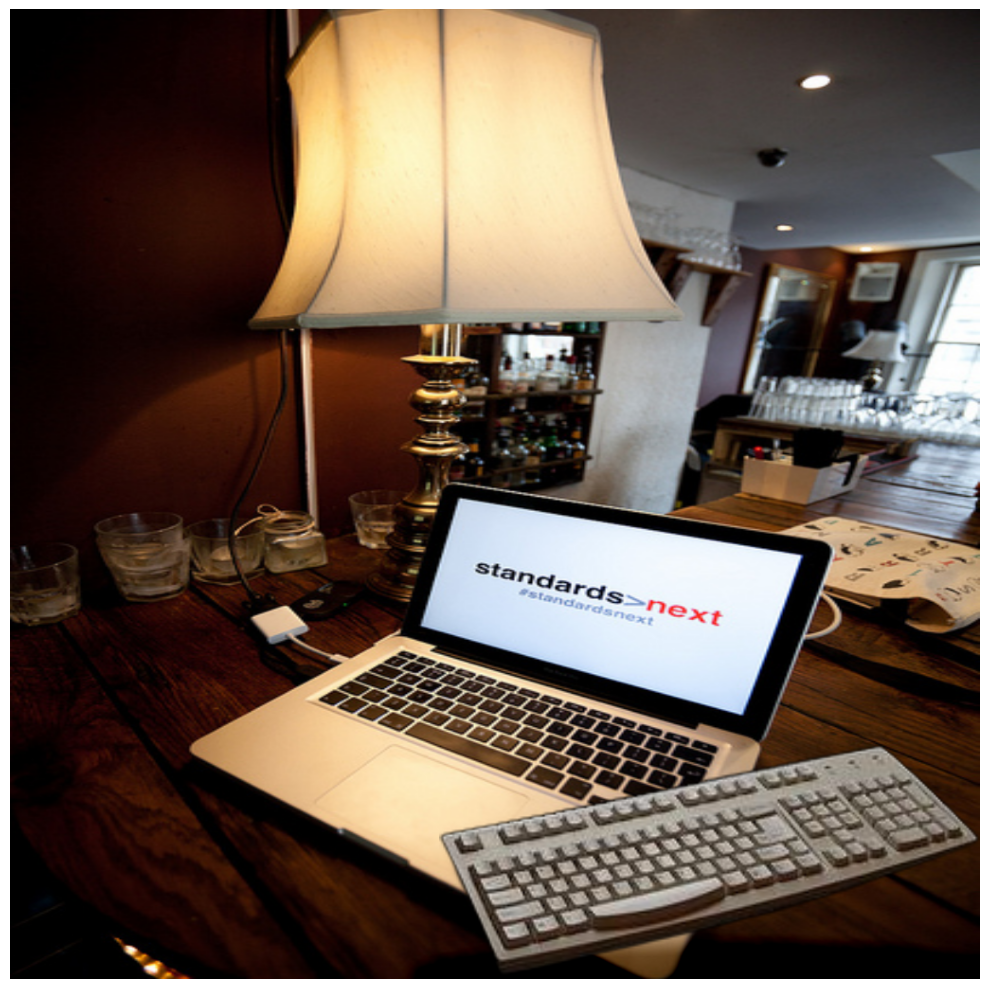

In [17]:
# User Interaction
from google.colab import files
from matplotlib import pyplot as plt

# Initialize placer
placer = AdvancedObjectPlacer(model, backgrounds)

# Upload and process
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
user_image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_UNCHANGED)

# Ensure proper color format
if user_image.shape[2] == 3:  # RGB
    user_image = cv2.cvtColor(user_image, cv2.COLOR_BGR2RGB)
else:  # RGBA
    user_image = cv2.cvtColor(user_image, cv2.COLOR_BGRA2RGBA)

# Generate result
result = placer.place_object(user_image)

# Display
plt.figure(figsize=(12, 10))
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()
